<a href="https://colab.research.google.com/github/BeltranMal/TA047R-2C2024-GRUPO01/blob/main/TA047R_TP2_GRUPO01_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import pandas as pd
from google.colab import drive
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest , f_regression
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
train = pd.read_csv('/content/drive/MyDrive/TP2: TA047R-2C2024-GRUPO01/train.csv')
test = pd.read_csv('/content/drive/MyDrive/TP2: TA047R-2C2024-GRUPO01/test.csv')

In [90]:
test.head(1)

,id,title,description,project
0,3433,Add Run > Tizen Emulator menu action in App an...,The action will create the launch shortcut for...,project8


In [91]:
train.head(1)
# Esta todo en ingles -> tiene caracteres especiales

,id,title,description,project,storypoint
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3


In [92]:
train.isna().sum() == 0

,0
id,True
title,True
description,True
project,True
storypoint,True


In [93]:
train.duplicated().sum()

0

# Preprocesamiento

habrá que realizar un preprocesamiento del texto para que este pueda ser analizado por los distintos modelos. Se utilizará el modelo de **bag of words**, **o cualquier otro** que permita convertir texto en vectores.

In [94]:
train["userStory"] = train["title"] + " " + train["description"]
train["userStory"] = train["userStory"].astype(str)
test["userStory"] = test["title"] + " " + test["description"]
test["userStory"] = test["userStory"].astype(str)
def limpieza_texto(userStory):
  userStory = userStory.map(lambda x:re.sub(r"[^\w\s]", "", x)) #elimina {} # etc
  userStory = userStory.map(lambda x: x.lower()) #convierte todo a minusculas
  userStory = userStory.map(lambda x: word_tokenize(x)) #convierte a tokens
  return userStory

train["userStory"] = limpieza_texto(train["userStory"])
test["userStory"] = limpieza_texto(test["userStory"])

In [95]:
stopWords = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
def preprocesamiento(userStory):
  userStoryFiltrado = []
  for word in userStory:
    if word not in stopWords:
      word = lemma.lemmatize(word)
      userStoryFiltrado.append(word)
  return userStoryFiltrado

train["userStory"] = train["userStory"].map(preprocesamiento)
test["userStory"] = test["userStory"].map(preprocesamiento)

In [96]:
train["userStory"] = train["userStory"].map(lambda x: " ".join(x))
test["userStory"] = test["userStory"].map(lambda x: " ".join(x))

<Axes: xlabel='storypoint', ylabel='count'>

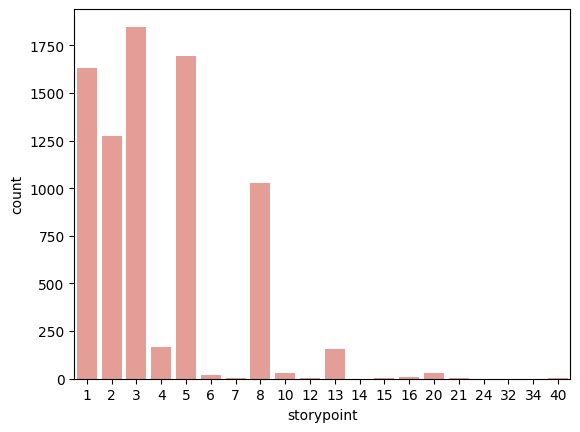

In [97]:
import seaborn as sns
sns.countplot(x=train["storypoint"], color="#F1948A")

In [98]:
#TF-IDF
vectorizer =  TfidfVectorizer()
X_tf = vectorizer.fit_transform(train["userStory"])
test_tf = vectorizer.transform(test["userStory"])
y = train["storypoint"]


# Funcion: create_submission

In [99]:
def create_submission(modelo, testeo, id):
    predictions = modelo.predict(testeo) # predicciones
    submission_df = pd.DataFrame({
        'id': id,
        'storypoint': predictions
    })
    submission_df.to_csv("entrega.csv", index=False)

#Bayes Naive Gauus

In [100]:
# Entrenamiento con Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.2, random_state=42)
modelo_bayes = GaussianNB()
modelo_bayes.fit(X_train_tf.toarray(), y_train_tf)

# Predicciones en el conjunto de prueba
y_pred = modelo_bayes.predict(X_test_tf.toarray())

# Calcular RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_test_tf, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 3.580184564933398


In [101]:
# Ver parametros del modelo
modelo_bayes.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [102]:
model_con_rs = GaussianNB()

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'var_smoothing': [1e-09, 1e-06,1e-04]
}

#grid search
grid_search = GridSearchCV(model_con_rs, param_grid=param_dist, cv=5, scoring='neg_root_mean_squared_error', verbose=True)
grid_search.fit(X_train_tf.toarray(), y_train_tf)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)
print("Mejor RMSE obtenido:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Realizar predicciones con el mejor modelo
y_pred = best_model.predict(X_test_tf.toarray())

# Calcular RMSE en el conjunto de prueba
rmse_test = np.sqrt(mean_squared_error(y_test_tf, y_pred))

print(f"RMSE en el conjunto de prueba con el mejor modelo: {rmse_test}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mejores hiperparámetros: {'var_smoothing': 0.0001}
Mejor RMSE obtenido: -3.678421938763775
RMSE en el conjunto de prueba con el mejor modelo: 3.5329372439402675


In [103]:
best_model.get_params()

{'priors': None, 'var_smoothing': 0.0001}

In [104]:
modelo_bayes = GaussianNB(**best_model.get_params())
modelo_bayes.fit(X_train_tf.toarray(), y_train_tf)

# Predicciones en el conjunto de prueba
y_pred = modelo_bayes.predict(X_test_tf.toarray())

# Calcular RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_test_tf, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 3.5329372439402675


In [105]:
print(mean_squared_error(y_test_tf, y_pred))

12.481645569620254


In [106]:
create_submission(modelo_bayes, test_tf.toarray(), test["id"])

#XGBoost

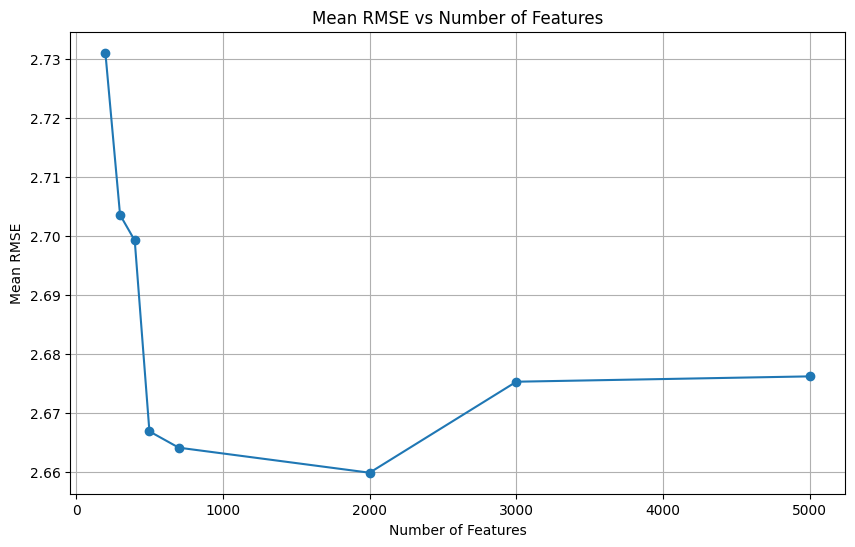

In [108]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor as xgb

feature_counts = [200, 300, 400, 500, 700, 2000, 3000,5000]

results = []

for k in feature_counts:

    selector = SelectKBest(f_regression, k=k)
    X_selected = selector.fit_transform(X_tf, y)
    test_selected = selector.transform(test_tf)

    model = xgb(eval_metric="rmse")
    scores = cross_val_score(model, X_selected, y, cv=5, scoring='neg_root_mean_squared_error')
    mean_rmse = -scores.mean()
    results.append((k, mean_rmse))

results_df = pd.DataFrame(results, columns=['Num_Features', 'Mean_RMSE'])



plt.figure(figsize=(10, 6))
plt.plot(results_df['Num_Features'], results_df['Mean_RMSE'], marker='o')
plt.title('Mean RMSE vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Mean RMSE')
plt.grid()
plt.show()

In [109]:
top2000 = SelectKBest(f_regression, k=2000)
X_tf = top2000.fit_transform(X_tf, y)
test_tf = top2000.transform(test_tf)

In [110]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.2, random_state=42)
xg_reg = xgb(eval_metric="rmse")

param_grid = {
    'n_estimators': [200,300],
    'learning_rate': [0.5, 0.1],
    'max_depth': [7, 9],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error',verbose=True)
grid_search.fit(X_train_tf, y_train_tf)
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}


In [111]:
#calcular RMSE
xg_reg = xgb(**best_params,eval_metric="rmse")
xg_reg.fit(X_train_tf, y_train_tf)
y_pred = xg_reg.predict(X_test_tf)
rmse_xgb = np.sqrt(mean_squared_error(y_test_tf, y_pred))
print("RMSE:", rmse_xgb)

RMSE: 2.3707962396014364


In [112]:
print(mean_squared_error(y_test_tf, y_pred))

5.62067480970831


#Random Forest

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint
import numpy as np

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_tf, y, test_size=0.2, random_state=42)

rf_reg_2 = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [3, 5, 7, 9, 11, 13],
    'min_samples_leaf': [10, 15, 20, 25, 30, 35],
}

random_search = RandomizedSearchCV(rf_reg_2, param_distributions=param_dist,
                                   n_iter=10, cv=5,
                                   scoring='neg_mean_squared_error',
                                   random_state=42, n_jobs=-1, verbose=2)

random_search.fit(X_train_rf, y_train_rf)

print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:  {'n_estimators': 150, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_depth': 30}
Best Score:  -7.670597715170099


In [114]:
rf_reg_randoms = random_search.best_estimator_
y_pred = rf_reg_randoms.predict(X_test_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred))
print("RMSE: ", rmse_rf)

RMSE:  2.484873804869578


In [115]:
create_submission(rf_reg_randoms, test_tf, test["id"])

# Red Neuronal

In [116]:
# Red neuronal
!pip install scikeras
from sklearn.neural_network import MLPRegressor
!pip install keras-tuner --upgrade
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.layers import Input
from scikeras.wrappers import KerasRegressor
np.random.seed(1)
tf.random.set_seed(1)

In [117]:
#hacer split
#X_train, X_test, y_train, y_test = train_test_split(train.drop(columns={"storypoint"}), train["storypoint"], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size=0.2, random_state=42)

In [118]:
X_train

<6320x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 69710 stored elements in Compressed Sparse Row format>

In [119]:
def armar_modelo():
  modelo = keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
])
  modelo.compile(
  optimizer= tf.keras.optimizers.Adam(learning_rate=0.0002), #keras.optimizers.SGD(learning_rate=0.0002),
  loss='mse',
  metrics=['mae'],
)
  return modelo


In [120]:
modelo = armar_modelo()

In [121]:
# Fit the model with a validation split and early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
modelo.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=True)

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 25.4412 - mae: 3.8418 - val_loss: 18.8619 - val_mae: 3.0909
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 17.6026 - mae: 2.8526 - val_loss: 9.7716 - val_mae: 1.9349
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 10.1404 - mae: 2.0513 - val_loss: 8.3212 - val_mae: 1.8926
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 9.2204 - mae: 2.0362 - val_loss: 8.0781 - val_mae: 1.8742
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 9.1642 - mae: 2.0287 - val_loss: 7.9131 - val_mae: 1.8463
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.5766 - mae: 1.9811 - val_loss: 7.7748 - val_mae: 1.8287
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.5139 - mae: 1.9439 - val_loss: 7.6684 - val_mae: 1.8025
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.0339 - mae: 1.9060 - val_loss: 7.5848 - val_mae: 1.7804
Epoch 9/100
158/158 ━━━━━━━━━━━━━━━━

In [122]:
y_pred = modelo.predict(X_test)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse_nn)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE:  2.3819632491670424


In [123]:
print(mean_squared_error(y_test, y_pred))

5.673748920382414


In [124]:
def submission_red(modelo, testeo, id):
    predictions = modelo.predict(testeo) # predicciones
    predictions = predictions.flatten()
    submission_df = pd.DataFrame({
        'id': id,
        'storypoint': predictions
    })
    submission_df.to_csv("red.csv", index=False)


In [125]:
submission_red(modelo, test_tf, test["id"])

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


# Ensamble

In [126]:
from sklearn.ensemble import VotingRegressor

In [127]:
# Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X_tf, train["storypoint"], test_size=0.2, random_state=42)

In [128]:
# Utilizamos los modelos anteriores
modelos_elegidos = [('modelo_xgb', xg_reg), ('modelo_randomforest', rf_reg_randoms), ('modelo_Red', KerasRegressor(model=armar_modelo))]

In [129]:
# Armamos el ensamble
VotingReg = VotingRegressor(estimators=modelos_elegidos, verbose = True)

# Lo entrenamos
VotingReg.fit(X_train, y_train)

# Predecimos con el Ensamble
y_pred = VotingReg.predict(X_test)

[Voting] ............... (1 of 3) Processing modelo_xgb, total= 1.3min
[Voting] ...... (2 of 3) Processing modelo_randomforest, total=  30.8s
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 26.2506 - mae: 3.8207
[Voting] ............... (3 of 3) Processing modelo_Red, total=   4.3s
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [130]:
# Calculamos el RMSE
rmse_ensamble = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse_ensamble)

RMSE:  2.626379859142283


In [131]:
print(mean_squared_error(y_test, y_pred))

6.897871164508239


In [132]:
create_submission(VotingReg, test_tf, test["id"])

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
